### Imports

In [1]:
import matplotlib
import parselmouth
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import librosa
from librosa.display import specshow, waveplot
import pandas as pd
from matplotlib import gridspec
from IPython.display import Audio
import scipy.signal as sig
sns.set_theme()

### Define parameters and variables

<ul>
    <li>start_time - start time of the segment that is to be plotted (seconds)</li>
    <li>end_time - end time of the segment that is to be plotted (seconds)</li>
    <li>guitar_audio_path - path to audio file from the guitar microphone</li>
    <li>mix_audio_path - path to the mix audio file to be analysed</li>
    <li>tabla_audio_path - path to the audio from the tabla microphone</li>
    <li>cycle_file - path to the file with annotation of sums in the song</li>
</ul>

In [2]:
start_time = 1435
end_time = 1455
guitar_audio_path = 'Data/NIR_DBh_Malhar_2Gats_Guitar.wav'
tabla_audio_path = 'Data/NIR_DBh_Malhar_2Gats_Tabla.wav'
mix_audio_path = 'Data/NIR_DBh_Malhar_2Gats_StereoMix.wav'
cycle_file = 'Data/NIR_DBh_Malhar_2Gats_Metre_DrutTeental.csv'

We load only the relevant part of the audio file here. Audio is loaded in mono, and sample rate is unchanged.

In [3]:
guitar_audio, guitar_sr = librosa.load(guitar_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
tabla_audio, tabla_sr = librosa.load(tabla_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
mix_audio, mix_sr = librosa.load(mix_audio_path, sr=None, mono=True, offset=start_time, duration = end_time - start_time)
cycle_df = pd.read_csv(cycle_file)
index_values = cycle_df.loc[(cycle_df['Time'] >= start_time) & (cycle_df['Time'] <= end_time)].index.values
annotated_beats = cycle_df.iloc[max(index_values[0]-1, 0):min(index_values[-1]+2, cycle_df.shape[0])]
# add all matras to show - each annotated beat has 4 divisions
# matras = []
# for ind, beats in enumerate(annotated_beats['Time'].values[:-1]):
#     matras.extend(np.around(np.linspace(beats, annotated_beats['Time'].values[ind+1], num = 2, endpoint=False), 2)[1:])

Use the sarod and tabla audio to generate spectograms

In [4]:
# stft params
winsize = int(np.ceil(guitar_sr*40e-3))
hopsize = int(np.ceil(guitar_sr*10e-3))
nfft = int(2**np.ceil(np.log2(winsize)))
# extract spectogram
f_guitar,t_guitar,X_guitar = sig.stft(guitar_audio, fs=guitar_sr, window='hann', nperseg=winsize, noverlap=(winsize-hopsize), nfft=nfft)
X_guitar_dB = librosa.power_to_db(np.abs(X_guitar), ref = np.max, amin=1e-5)
f_tabla,t_tabla,X_tabla = sig.stft(tabla_audio, fs=tabla_sr, window='hann', nperseg=winsize, noverlap=(winsize-hopsize), nfft=nfft)
X_tabla_dB = librosa.power_to_db(np.abs(X_tabla), ref = np.max, amin=1e-5)

Play the audio being analysed

In [5]:
Audio(mix_audio, rate=mix_sr)

Plotting the spectograms of tabla and sarod

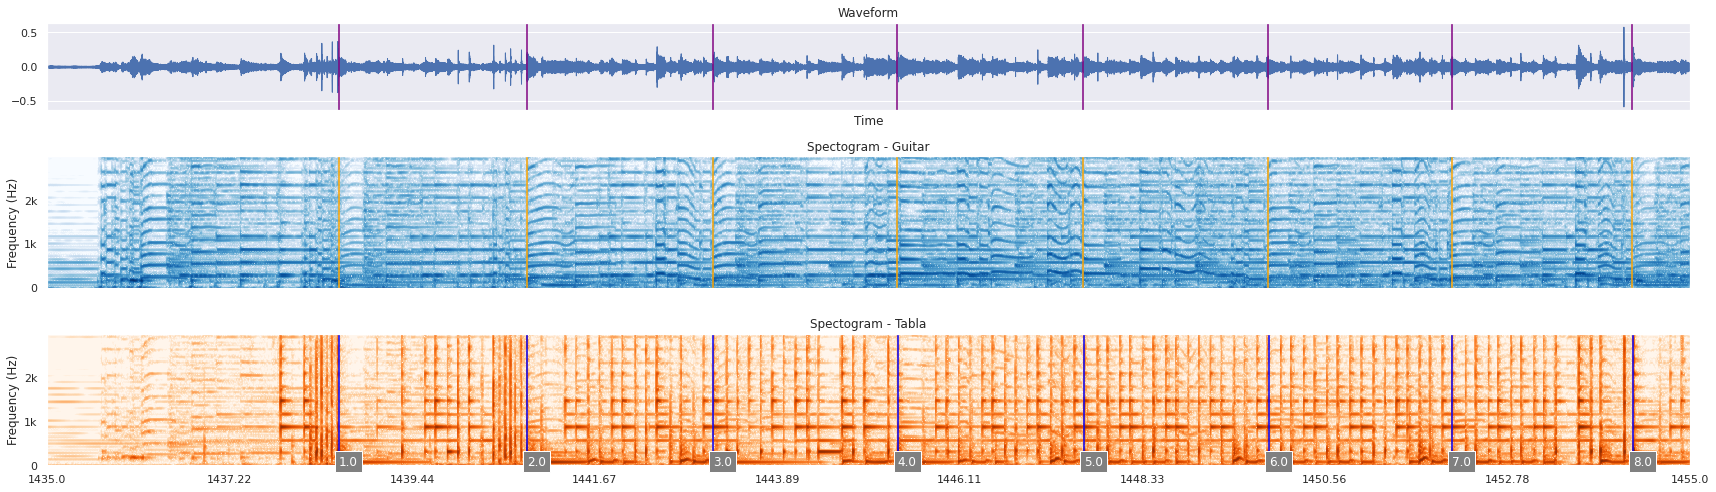

In [6]:
fig = plt.figure(figsize=(24, 7))
specs = fig.add_gridspec(3, 1, height_ratios = [2, 3, 3])
axs = [fig.add_subplot(specs[0, 0]), fig.add_subplot(specs[1, 0]), fig.add_subplot(specs[2, 0])]
#plot the waveform
waveplot(mix_audio, mix_sr, ax=axs[0])
axs[0].set(title='Waveform')
#plot spectograms
specshow(X_guitar_dB, x_axis='time', y_axis='linear', sr=guitar_sr, fmax=guitar_sr//2, hop_length=hopsize, ax=axs[1], cmap='Blues')
specshow(X_tabla_dB, x_axis='time', y_axis='linear', sr=tabla_sr, fmax=tabla_sr//2, hop_length=hopsize, ax=axs[2], cmap='Oranges')
axs[1].set(ylabel='Frequency (Hz)', xlabel='', title='Spectogram - Guitar')
axs[2].set(ylabel='Frequency (Hz)', xlabel='', title='Spectogram - Tabla')
for i, beat in annotated_beats.iterrows():
    # plot annotated beats
    if beat['Time'] >= start_time and beat['Time'] <= end_time:
        axs[0].axvline(beat['Time']-start_time, linestyle='-', c='purple')
        axs[1].axvline(beat['Time']-start_time, linestyle='-', c='orange')
        axs[2].axvline(beat['Time']-start_time, linestyle='-', c='blue')
        axs[2].annotate(beat['Cycle'], (beat['Time']-start_time, -0.4), bbox=dict(facecolor='grey', edgecolor='white'), c='white')
#     for matra in matras:
#     # plot beats in the middle
#         if matra >= start_time and matra <= end_time:
#             axs[0].axvline(matra-start_time, linestyle='-', c='purple')
#             axs[1].axvline(matra-start_time, linestyle='-', c='orange')
#             axs[2].axvline(matra-start_time, linestyle='-', c='blue')
axs[2].set_xlim(0, end_time-start_time)
axs[2].set_xticks(np.linspace(0, end_time-start_time, 10))
axs[2].set_xticklabels(np.around(np.linspace(0, end_time-start_time, 10) + start_time, 2))
axs[1].set_xticks([])
axs[0].set_xticks([])
axs[0].set_xlim(axs[1].get_xlim())
axs[1].set_ylim(0, 3000)
axs[1].set_yticks([0, 1e3, 2e3])
axs[1].set_yticklabels(['0', '1k', '2k'])
axs[2].set_ylim(0, 3000)
axs[2].set_yticks([0, 1e3, 2e3])
axs[2].set_yticklabels(['0', '1k', '2k'])
fig.tight_layout()